In [1]:
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'
# Request header
headers = {'ContentType': 'json'}
resource = 'locagrid'

def process_daily_data(slug, city_id, city_name):
    # Make request
    url = api + '/series/' + slug + '/events/?ref=/api/' + resource + '/%s/&imperial=TRUE&stat=mean' % city_id
    response = requests.get(url)
    #print(response)
    # Get data
    if response.ok:
        data = response.json()
        df = pd.DataFrame(data)
        df.set_index('index', inplace = True)
        df.index = pd.to_datetime(df.index)
        df['city'] = city_name
    else:
        print('Failed to download:')
    return df

In [3]:
model = 'CanESM2'
def get_projections(city_id, city_name):
    # Create an empty list to hold dataframes
    df_list = []
    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['tasmax']
    period = ['day']
    models = [model]
    #models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5', 'ACCESS1-0', 'CCSM4', 'CESM1-BGC', 'CMCC-CMS', 'GFDL-CM3', 'HadGEM2-CC']
    #models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5']
    #scenarios = ['rcp45', 'rcp85', 'historical]
    scenarios = ['historical', 'rcp85', ]
    zipped = itertools.product(climvar, period, models, scenarios)
    
    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, city_id, city_name)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [4]:
city_names = ['Sac', 'SD', 'LA', 'SB', 'Fresno', 'SJ']                                                       
points = ['POINT(-121.4944 36.5816)', 'POINT(-117.1611 32.7157)','POINT(-118.2437 34.0522)', 'POINT(-119.6982 34.4208)', 'POINT(-119.7871 36.7378)', 'POINT(-121.8863 37.3382)' ]


def projection_for_all_cities():
    df_all_cities = []
    # Cal-Adapt API
    api = 'http://api.cal-adapt.org/api'
    # Name of boundary layer in API (Census Tracts)
    resource = 'locagrid'
    #Get ID
    for i, j in zip(points, city_names) :
        url = api + '/' + resource + '/?intersects=' +  i
        response = requests.get(url)
        county = response.json()
        county = county['features'][0]
        city_id  = county['id']
        df = get_projections(city_id, j)
        df_all_cities.append(df)
    return pd.concat(df_all_cities)
    #location = 'Census Tract ID ' + str(county['properties']['tract'])

In [5]:
city_names = ['Sac', 'SD', 'LA', 'SB', 'Fresno', 'SJ']

In [6]:
df = projection_for_all_cities()
df.head()

,name,data,city
index,,,
1950-01-01 00:00:00+00:00,tasmax_day_CanESM2_historical,61.542839,Sac
1950-01-02 00:00:00+00:00,tasmax_day_CanESM2_historical,59.291191,Sac
1950-01-03 00:00:00+00:00,tasmax_day_CanESM2_historical,59.059875,Sac
1950-01-04 00:00:00+00:00,tasmax_day_CanESM2_historical,62.675308,Sac
1950-01-05 00:00:00+00:00,tasmax_day_CanESM2_historical,55.707619,Sac


In [7]:
# Keep only required parameters in slug
df['Climate Data'] = df['name'].str.split('_', expand=True)[2] 
df.index.name = 'Date'
df.drop(columns= 'name', inplace = True)
df.head()

,data,city,Climate Data
Date,,,
1950-01-01 00:00:00+00:00,61.542839,Sac,CanESM2
1950-01-02 00:00:00+00:00,59.291191,Sac,CanESM2
1950-01-03 00:00:00+00:00,59.059875,Sac,CanESM2
1950-01-04 00:00:00+00:00,62.675308,Sac,CanESM2
1950-01-05 00:00:00+00:00,55.707619,Sac,CanESM2


In [8]:
df = df[(df.index.month == 5) | (df.index.month == 6) |(df.index.month == 7) | (df.index.month == 8) | (df.index.month == 9) ] # | df.index.month == 7 | df.index.month == 8 | df.index.month == 9]

In [9]:
df.head()

,data,city,Climate Data
Date,,,
1950-05-01 00:00:00+00:00,66.787491,Sac,CanESM2
1950-05-02 00:00:00+00:00,69.563522,Sac,CanESM2
1950-05-03 00:00:00+00:00,73.353142,Sac,CanESM2
1950-05-04 00:00:00+00:00,72.401947,Sac,CanESM2
1950-05-05 00:00:00+00:00,69.443985,Sac,CanESM2


In [10]:
df = df.pivot_table( values = 'data', index = df.index, columns = 'city')

In [11]:
df.head()

city,Fresno,LA,SB,SD,SJ,Sac
Date,,,,,,
1950-05-01 00:00:00+00:00,81.300430,74.782791,65.460449,68.768433,71.084190,66.787491
1950-05-02 00:00:00+00:00,82.410156,75.632690,77.999039,68.658798,70.316795,69.563522
1950-05-03 00:00:00+00:00,91.674927,79.363762,77.191330,71.472061,82.857849,73.353142
1950-05-04 00:00:00+00:00,86.567062,78.475739,73.609177,73.497177,79.515976,72.401947
1950-05-05 00:00:00+00:00,82.587540,77.566010,69.207397,72.526917,69.312042,69.443985


In [12]:
historical = df.loc['1961-01-01':'1990-12-31', :]

In [13]:
historical.head()

city,Fresno,LA,SB,SD,SJ,Sac
Date,,,,,,
1961-05-01 00:00:00+00:00,78.790604,79.907860,67.997421,72.751587,71.284416,71.512497
1961-05-02 00:00:00+00:00,75.039978,74.263031,70.339096,67.427612,67.748413,65.522797
1961-05-03 00:00:00+00:00,74.846024,74.913361,69.247116,69.902557,65.009247,67.889206
1961-05-04 00:00:00+00:00,81.420013,77.602325,69.830261,70.572830,84.503387,76.001556
1961-05-05 00:00:00+00:00,83.755768,75.551727,69.992973,68.145233,83.081314,78.488815


In [14]:
percentile = historical.quantile(.90)

In [15]:
percentile

city
Fresno    102.689894
LA         91.339771
SB         80.666294
SD         80.957681
SJ         90.561034
Sac        83.754958
Name: 0.9, dtype: float64

In [16]:
len(city_names)

6

In [17]:
# Only days when each city temp is greater than the selected percentile of city historical 
for city, threshold in zip(city_names, percentile):
    df = df[df[city] > threshold]

In [18]:
df.head()

city,Fresno,LA,SB,SD,SJ,Sac
Date,,,,,,
2012-09-20 00:00:00+00:00,106.594971,100.951347,83.547470,105.706398,95.885437,105.686127
2052-09-01 00:00:00+00:00,110.647552,102.585892,93.789307,93.139191,105.958366,105.451729
2053-07-10 00:00:00+00:00,114.427948,109.417740,97.653801,97.922798,105.451729,104.245323
2063-06-18 00:00:00+00:00,113.204620,105.702217,85.834160,91.892136,103.674202,104.248894
2067-09-20 00:00:00+00:00,108.958839,111.242294,112.094505,103.289017,96.914864,103.276108


In [19]:
df['avg'] = df.loc[:, ['Fresno', 'LA', 'SB', 'SD', 'SJ', 'Sac']].mean(axis = 1)

In [20]:
df.shape

(47, 7)

In [21]:
df['period'] = df.index.strftime('%m-%d')

In [22]:
df['month'] = df.index.month
df['day'] = df.index.day

In [23]:
#df = df.loc['1961-01-01': '2060-12-31', :]

In [24]:
df.tail()

city,Fresno,LA,SB,SD,SJ,Sac,avg,period,month,day
Date,,,,,,,,,,
2098-09-03 00:00:00+00:00,111.154022,111.206917,92.456055,101.243584,103.386192,102.904549,103.725220,09-03,9,3
2098-09-04 00:00:00+00:00,113.124092,116.817909,101.915565,103.484138,107.943924,103.128510,107.735690,09-04,9,4
2098-09-30 00:00:00+00:00,102.952286,104.390396,92.942429,93.791885,102.029274,105.357857,100.244021,09-30,9,30
2100-08-26 00:00:00+00:00,112.981377,111.068436,98.417572,96.375160,107.647186,105.165260,105.275832,08-26,8,26
2100-08-27 00:00:00+00:00,114.631523,113.524208,100.447182,99.771744,107.670311,107.227943,107.212152,08-27,8,27


In [25]:
df2 = df.sort_values(by = ['month', 'day'])

In [26]:
df2.head()

city,Fresno,LA,SB,SD,SJ,Sac,avg,period,month,day
Date,,,,,,,,,,
2096-06-16 00:00:00+00:00,119.400299,109.450371,89.747604,94.261993,104.754982,102.987442,103.433782,06-16,6,16
2063-06-18 00:00:00+00:00,113.204620,105.702217,85.834160,91.892136,103.674202,104.248894,100.759371,06-18,6,18
2096-07-01 00:00:00+00:00,121.375587,108.877655,85.802139,91.586823,115.152824,105.124008,104.653173,07-01,7,1
2053-07-10 00:00:00+00:00,114.427948,109.417740,97.653801,97.922798,105.451729,104.245323,104.853223,07-10,7,10
2088-07-11 00:00:00+00:00,122.406380,108.243080,98.422516,93.136887,105.593842,103.151741,105.159074,07-11,7,11


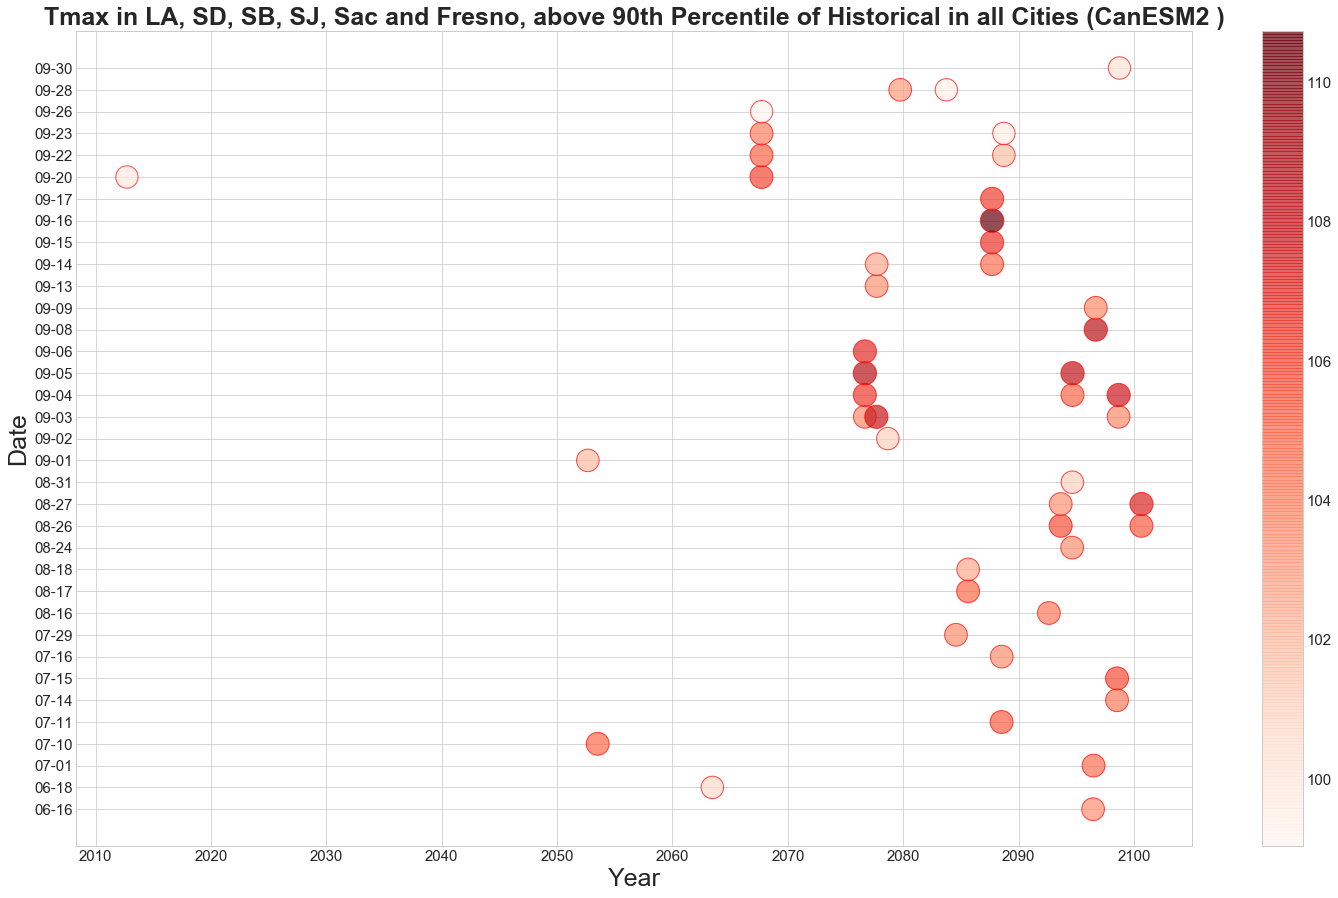

In [28]:
plt.scatter(x = df2.index, y = df2.period, s = df2.avg*5, alpha = 0.7, c = df2.avg,  cmap = 'Reds', edgecolors='Red')
#my_yticks = ['05-16', '05-26', '06-06', '06-16', '06-26', '07-06', '07-16', '07-26', '08-06', '08-16', '08-26', '09-06', '09-16', '09-26']
#plt.yticks(my_yticks)
plt.grid(True)
plt.rcParams['figure.figsize'] = [25, 15]
plt.xlabel('Year', fontsize = 25)

plt.ylabel('Date', fontsize = 25)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
plt.colorbar()
plt.title('Tmax in LA, SD, SB, SJ, Sac and Fresno, above 90th Percentile of Historical in all Cities (' + model + ' )', weight = 'bold', fontsize = 25)
#labels = ['May 16', 'May 26', 'June 06', 'June 16', 'June 26', 'July 06', 'July 16', 'July 26', 'Aug 6', 'Aug 16', 'Aug 26', 'Sep 06', 'Sep 16', 'Sep 26']
ax = plt.gca() # grab the current axis
plt.style.use('seaborn-whitegrid')
#ax.set_yticklabels(labels) # set the labels to display at those ticks
plt.show()